# **Data input 2D**

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix



In [2]:
df1 = pd.read_csv("1-RDkit-2D_scal_aug_data.csv")

In [ ]:
df1.head()

,MaxEStateIndex,MinEStateIndex,MinAbsEStateIndex,qed,MolWt,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,values
0,-1.087494,0.184938,1.355860,-0.492646,-1.397166,-0.01309,1.990064,-0.450123,0.934959,1.514625,...,-0.353118,-0.132878,-0.071864,-0.09503,-0.190349,-0.006742,-0.139942,0.0,-0.237666,1
1,-1.620405,0.222410,-1.098739,1.870766,-0.478515,-0.01309,-2.271368,1.445307,-0.431758,-1.425608,...,-0.353118,-0.132878,-0.071864,-0.09503,-0.190349,-0.006742,-0.139942,0.0,-0.237666,1
2,1.430229,-2.388664,1.813916,-1.350621,1.680917,-0.01309,0.341549,-0.277731,-1.218088,-1.425608,...,-0.353118,-0.132878,-0.071864,-0.09503,-0.190349,-0.006742,-0.139942,0.0,-0.237666,1
3,1.235464,0.425966,-0.940453,0.918686,-0.063607,-0.01309,0.742523,-0.519010,1.150263,0.687203,...,-0.353118,-0.132878,-0.071864,-0.09503,-0.190349,-0.006742,-0.139942,0.0,-0.237666,1
4,-1.470073,-0.782032,1.069193,-1.688096,0.479021,-0.01309,-1.017933,0.610565,-0.686159,-1.425608,...,-0.353118,-0.132878,-0.071864,-0.09503,-0.190349,-0.006742,-0.139942,0.0,-0.237666,1


In [3]:
# Separate features and target
X = df1.drop(columns=["values"]).values  # Molecular descriptors (features)
y = df1["values"].values  # Target variable (binary classification)


# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

ValueError: Input y contains NaN.

In [4]:
# Separate features and target
# Before separating features and target, drop rows with NaN in the target column
df1.dropna(subset=["values"], inplace=True)

X = df1.drop(columns=["values"]).values  # Molecular descriptors (features)
y = df1["values"].values  # Target variable (binary classification)


# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [5]:
X.shape

(13006, 140)

In [7]:
y.shape

(13006,)

# **NN 2D relu**

In [8]:
# Define Neural Network
class MolecularNN(nn.Module):
    def __init__(self, input_dim):
        super(MolecularNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)  # Increased neurons for non-linearity
        self.bn1 = nn.BatchNorm1d(256)  # Batch normalization for stable training
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1)  # Binary classification output
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout to prevent overfitting
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.sigmoid(self.fc4(x))  # Sigmoid for binary classification
        return x

# Initialize model
input_dim = X_train.shape[1]  # Number of molecular descriptors
model = MolecularNN(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()  # Backpropagation
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [5/500], Loss: 0.6568
Epoch [10/500], Loss: 0.5935
Epoch [15/500], Loss: 0.5474
Epoch [20/500], Loss: 0.5152
Epoch [25/500], Loss: 0.4887
Epoch [30/500], Loss: 0.4691
Epoch [35/500], Loss: 0.4547
Epoch [40/500], Loss: 0.4418
Epoch [45/500], Loss: 0.4323
Epoch [50/500], Loss: 0.4232
Epoch [55/500], Loss: 0.4156
Epoch [60/500], Loss: 0.4080
Epoch [65/500], Loss: 0.4004
Epoch [70/500], Loss: 0.3938
Epoch [75/500], Loss: 0.3893
Epoch [80/500], Loss: 0.3846
Epoch [85/500], Loss: 0.3779
Epoch [90/500], Loss: 0.3728
Epoch [95/500], Loss: 0.3667
Epoch [100/500], Loss: 0.3632
Epoch [105/500], Loss: 0.3574
Epoch [110/500], Loss: 0.3529
Epoch [115/500], Loss: 0.3492
Epoch [120/500], Loss: 0.3416
Epoch [125/500], Loss: 0.3388
Epoch [130/500], Loss: 0.3349
Epoch [135/500], Loss: 0.3286
Epoch [140/500], Loss: 0.3268
Epoch [145/500], Loss: 0.3247
Epoch [150/500], Loss: 0.3197
Epoch [155/500], Loss: 0.3145
Epoch [160/500], Loss: 0.3143
Epoch [165/500], Loss: 0.3069
Epoch [170/500], Loss: 0.3057


In [9]:
# Evaluate model
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_labels = (y_pred_test >= 0.5).float()  # Convert probabilities to binary labels

# Convert tensors to numpy for metrics calculation
y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred_labels.numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)
roc_auc = roc_auc_score(y_test_np, y_pred_test.numpy())
conf_matrix = confusion_matrix(y_test_np, y_pred_np)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.7656
Precision: 0.8312
Recall: 0.8815
F1-score: 0.8556
ROC AUC: 0.7178
Confusion Matrix:
[[ 185  367]
 [ 243 1807]]


# **Optimized NN 2D leaky relu**

In [10]:
class ImprovedMolecularNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedMolecularNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.fc4 = nn.Linear(128, 64)
        self.bn4 = nn.BatchNorm1d(64)
        self.fc5 = nn.Linear(64, 1)

        self.leaky_relu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.4)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.leaky_relu(self.bn4(self.fc4(x)))
        x = self.sigmoid(self.fc5(x))
        return x

# Initialize model
input_dim = X_train.shape[1]  # Number of molecular descriptors
model = ImprovedMolecularNN(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()  # Backpropagation
    optimizer.step()

    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [5/500], Loss: 0.6103
Epoch [10/500], Loss: 0.5553
Epoch [15/500], Loss: 0.5178
Epoch [20/500], Loss: 0.4893
Epoch [25/500], Loss: 0.4691
Epoch [30/500], Loss: 0.4541
Epoch [35/500], Loss: 0.4430
Epoch [40/500], Loss: 0.4340
Epoch [45/500], Loss: 0.4251
Epoch [50/500], Loss: 0.4164
Epoch [55/500], Loss: 0.4090
Epoch [60/500], Loss: 0.4042
Epoch [65/500], Loss: 0.3949
Epoch [70/500], Loss: 0.3901
Epoch [75/500], Loss: 0.3868
Epoch [80/500], Loss: 0.3805
Epoch [85/500], Loss: 0.3755
Epoch [90/500], Loss: 0.3715
Epoch [95/500], Loss: 0.3657
Epoch [100/500], Loss: 0.3639
Epoch [105/500], Loss: 0.3582
Epoch [110/500], Loss: 0.3505
Epoch [115/500], Loss: 0.3462
Epoch [120/500], Loss: 0.3405
Epoch [125/500], Loss: 0.3402
Epoch [130/500], Loss: 0.3369
Epoch [135/500], Loss: 0.3367
Epoch [140/500], Loss: 0.3288
Epoch [145/500], Loss: 0.3284
Epoch [150/500], Loss: 0.3213
Epoch [155/500], Loss: 0.3197
Epoch [160/500], Loss: 0.3193
Epoch [165/500], Loss: 0.3092
Epoch [170/500], Loss: 0.3073


In [11]:
# Evaluate model
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_labels = (y_pred_test >= 0.5).float()  # Convert probabilities to binary labels

# Convert tensors to numpy for metrics calculation
y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred_labels.numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)
roc_auc = roc_auc_score(y_test_np, y_pred_test.numpy())
conf_matrix = confusion_matrix(y_test_np, y_pred_np)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.7579
Precision: 0.8417
Recall: 0.8532
F1-score: 0.8474
ROC AUC: 0.7346
Confusion Matrix:
[[ 223  329]
 [ 301 1749]]


# **Early stopping 2D features**

In [12]:
from sklearn.model_selection import train_test_split

# Load and preprocess data
X = df1.drop(columns=["values"]).values  # Features (molecular descriptors)
y = df1["values"].values  # Target variable (binary classification)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [13]:
# Training loop with Early Stopping
epochs = 5000
best_loss = float('inf')
counter = 0
patience = 50  # Stop training if validation loss doesn't improve for 50 epochs

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Validation phase
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val_tensor)
        val_loss = criterion(val_pred, y_val_tensor)  # Now correctly defined

    # Check early stopping condition
    if val_loss.item() < best_loss - 0.001:
        best_loss = val_loss.item()
        counter = 0  # Reset counter
        best_model = model.state_dict()  # Save best model
    else:
        counter += 1  # Increase counter if no improvement

    if counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    # Print loss every 10 epochs
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

# Load the best model before testing
model.load_state_dict(best_model)


Epoch [5/5000], Train Loss: 0.1974, Val Loss: 0.5490
Epoch [10/5000], Train Loss: 0.2005, Val Loss: 0.5506
Epoch [15/5000], Train Loss: 0.1964, Val Loss: 0.5598
Epoch [20/5000], Train Loss: 0.1929, Val Loss: 0.5632
Epoch [25/5000], Train Loss: 0.1962, Val Loss: 0.5695
Epoch [30/5000], Train Loss: 0.1904, Val Loss: 0.5752
Epoch [35/5000], Train Loss: 0.1926, Val Loss: 0.5820
Epoch [40/5000], Train Loss: 0.1872, Val Loss: 0.5885
Epoch [45/5000], Train Loss: 0.1864, Val Loss: 0.5917
Epoch [50/5000], Train Loss: 0.1894, Val Loss: 0.5974
Early stopping at epoch 51


<All keys matched successfully>

In [14]:
# Evaluate model on the test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    y_pred_labels = (y_pred_test >= 0.5).float()  # Convert probabilities to binary labels

# Convert tensors to numpy for metric calculations
y_test_np = y_test_tensor.numpy()
y_pred_np = y_pred_labels.numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_np, y_pred_np)
precision = precision_score(y_test_np, y_pred_np)
recall = recall_score(y_test_np, y_pred_np)
f1 = f1_score(y_test_np, y_pred_np)
roc_auc = roc_auc_score(y_test_np, y_pred_test.numpy())
conf_matrix = confusion_matrix(y_test_np, y_pred_np)

# Print evaluation results
print("\n--- Final Model Evaluation on Test Set ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)



--- Final Model Evaluation on Test Set ---
Accuracy: 0.7817
Precision: 0.8638
Recall: 0.8582
F1-score: 0.8610
ROC AUC: 0.7824
Confusion Matrix:
[[ 206  208]
 [ 218 1319]]


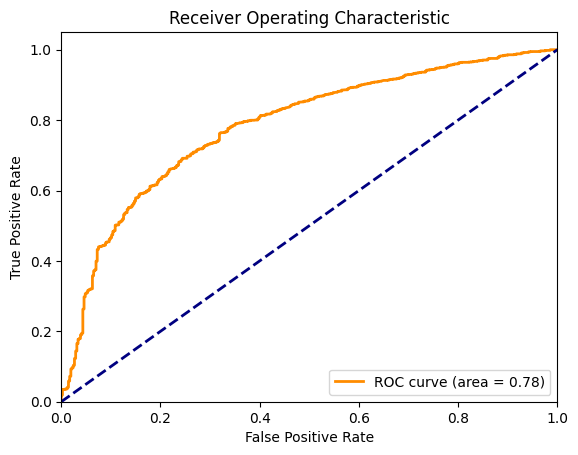

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have y_test_np and y_pred_test from your code
fpr, tpr, thresholds = roc_curve(y_test_np, y_pred_test.numpy())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


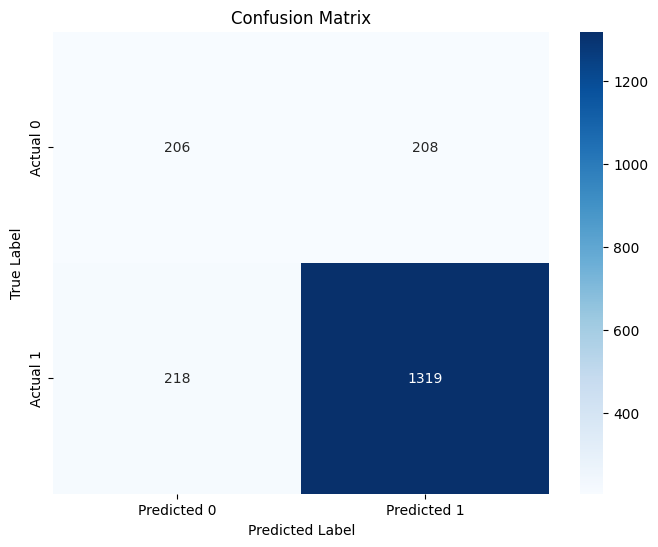

In [16]:
# prompt: draw confusion marix

import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [17]:
# Save trained model
torch.save(model, "2D rdki best nn_model.pth")
print("Best model saved as 'best_molecular_nn_model.pth'")


Best model saved as 'best_molecular_nn_model.pth'


In [18]:
# prompt: save the model in pkl format

import pickle

# Save the entire model in pkl format
with open('2D_rdki_best_nn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Best model saved as '2D_rdki_best_nn_model.pkl'")

Best model saved as '2D_rdki_best_nn_model.pkl'


In [19]:
feature_names = df1.drop(columns=["values"]).columns
feature_importances = model.fc1.weight.detach().numpy().mean(axis=0)  # Example, replace with your model's feature importance extraction

# Create a dataframe with feature importances
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by="importance", ascending=False)

# Print or visualize the top 20 features
print("Top 20 Features:")
print(feature_importance_df.head(20))



Top 20 Features:
                 feature  importance
95     fr_benzodiazepine    0.043286
112            fr_lactam    0.037810
110       fr_isothiocyan    0.037444
5    NumRadicalElectrons    0.028857
121             fr_oxime    0.023111
72             fr_Ar_COO    0.021452
70       fr_Al_OH_noTert    0.020825
97              fr_diazo    0.018786
40            SlogP_VSA1    0.017384
79                fr_NH1    0.017245
93                fr_azo    0.017068
3                    qed    0.016688
136          fr_thiocyan    0.015848
135          fr_thiazole    0.013582
49          EState_VSA11    0.013557
15              BalabanJ    0.013075
46            SlogP_VSA8    0.013052
128          fr_pyridine    0.012922
111            fr_ketone    0.012797
98    fr_dihydropyridine    0.011238


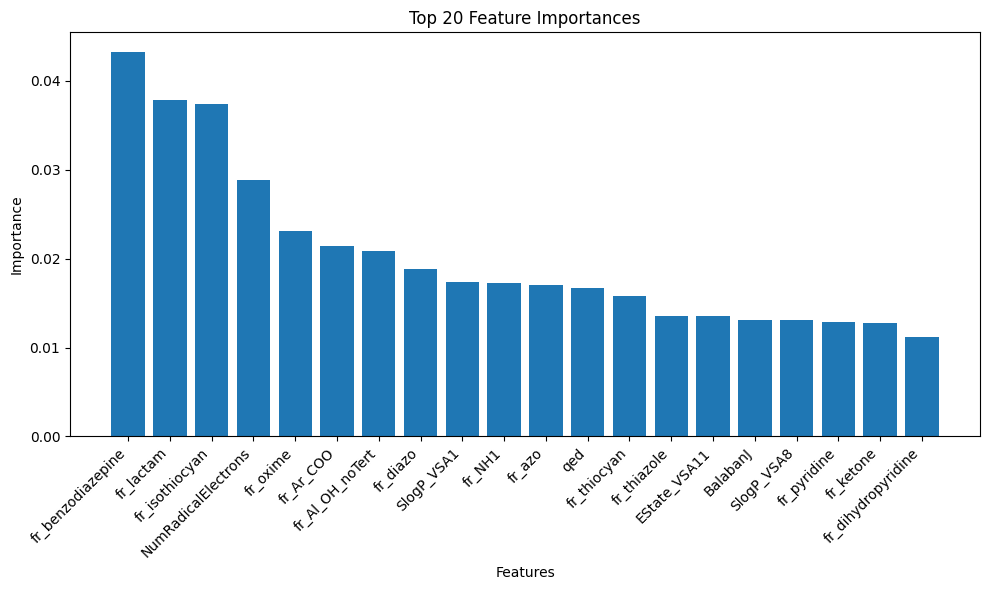

In [20]:
import matplotlib.pyplot as plt

# Assuming feature_importance_df is already created as in your previous code

# Select top 10 features
top_10_features = feature_importance_df.head(20)

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(top_10_features['feature'], top_10_features['importance'])
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Top 20 Feature Importances")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()
